# Load Library

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn.datasets as datasets
from sklearn.cluster import KMeans, AgglomerativeClustering
import time
torch.manual_seed(0)

In [ ]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset from the drive
# This assignment is done using Google Colab. Change drive_path accordingly to read and save files
drive_path = '/content/drive/MyDrive/Colab Notebooks/comp4331/asgn3'

Mounted at /content/drive


## Sentiment Analysis (Multilayer Perceptron)

In [ ]:
# load dataset
data_path = "preprocessed_data.csv"
data = pd.read_csv(drive_path + '/' + data_path)
feature_names = data.columns[:-1]
data = data.to_numpy()
X = data[:, :-1]
y = data[:, -1]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Function for data preprocessing
def generate_dataloader(X_train, X_test, y_train, y_test):
    # convert data to proper data types
    X_train = torch.tensor(X_train, dtype=torch.float)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float)
    y_test = torch.tensor(y_test, dtype=torch.long)
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    # # generate dataloader
    batch_size = 500
    train_dataset = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = DataLoader(test_dataset, batch_size=batch_size)

    return train_dataset, test_dataset

In [ ]:

# Function for building MLP with variable number of hidden layers
def build_mlp(nbr_hidden_nodes):
    mlp = nn.Sequential(
        # add hidden layers, use ReLU activation function and nbr_hidden_nodes

        nn.Linear(X.shape[1], nbr_hidden_nodes),
        nn.ReLU(),
        nn.Linear(nbr_hidden_nodes, 3),

    )
    print(f'You have defined the following MLP components: \n{mlp}')
    return mlp


In [ ]:

# Function for MLP training
def train_mlp(mlp, learning_rate, epoches, train_dataset):
    lossFunc = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

    for i_epoch in range(epoches):
        print(f'\nEpoch: {i_epoch+1}')
        mlp.train()

        for i, (inputs, labels) in enumerate(train_dataset):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + compute loss + backward + optimize
            # forward + compute loss + backward + optimize

            outputs = mlp(inputs)
            loss = lossFunc(outputs, labels)
            loss.backward()
            optimizer.step()

            print("loss", loss)

In [ ]:
# Function for MLP testing
def evaluate_mlp(mlp, train_dataset, test_dataset):
    mlp.eval() # toggle evaluation mode
    # define an evaluation function

    # evaluation
    train_acc = evaluate_a_mlp(mlp, train_dataset)
    test_acc = evaluate_a_mlp(mlp, test_dataset)
    # print(f'\nFinal training accuracy: {train_acc:.2f}%\tFinal testing accuracy: {test_acc:.2f}%')
    return train_acc, test_acc

def evaluate_a_mlp(mlp, dataloader):
    correct = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            output = mlp(inputs)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).sum()
    accuracy = correct.true_divide(len(dataloader.dataset))
    return accuracy


You have defined the following MLP components: 
Sequential(
  (0): Linear(in_features=1500, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=3, bias=True)
)

Epoch: 1
loss tensor(1.0559, grad_fn=<NllLossBackward0>)
loss tensor(1.0369, grad_fn=<NllLossBackward0>)
loss tensor(1.0371, grad_fn=<NllLossBackward0>)
loss tensor(1.0348, grad_fn=<NllLossBackward0>)
loss tensor(1.0246, grad_fn=<NllLossBackward0>)
loss tensor(1.0094, grad_fn=<NllLossBackward0>)
loss tensor(0.9955, grad_fn=<NllLossBackward0>)
loss tensor(0.9878, grad_fn=<NllLossBackward0>)

Epoch: 2
loss tensor(0.9713, grad_fn=<NllLossBackward0>)
loss tensor(0.9547, grad_fn=<NllLossBackward0>)
loss tensor(0.9524, grad_fn=<NllLossBackward0>)
loss tensor(0.9141, grad_fn=<NllLossBackward0>)
loss tensor(0.9159, grad_fn=<NllLossBackward0>)
loss tensor(0.8848, grad_fn=<NllLossBackward0>)
loss tensor(0.9063, grad_fn=<NllLossBackward0>)
loss tensor(0.8698, grad_fn=<NllLossBackward0>)

Epoch: 3
loss tensor

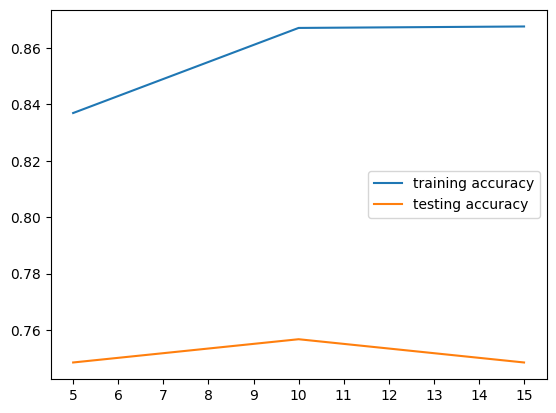

In [ ]:
# Use functions to build, train, evaluate MLP
learning_rate = 5e-3
epoches = 8
nbrs_hidden_nodes = [5, 10, 15]
torch.manual_seed(0)

train_dataset, test_dataset = generate_dataloader(X_train, X_test, y_train, y_test)

train_accs = []
test_accs = []
for nbr_nodes in nbrs_hidden_nodes:
	#######################
	# TODO Q2.3
    # build, train, evaluate MLP
    mlp = build_mlp(nbr_nodes)
    train_mlp(mlp, learning_rate, epoches, train_dataset)
    train_acc, test_acc = evaluate_mlp(mlp, train_dataset, test_dataset)

    train_accs.append(train_acc)
    test_accs.append(test_acc)
    #######################
    print("nbr of hidden nodes:", nbr_nodes, "training accuracy:", train_acc, "testing accuracy:", test_acc)


# plot training and testing accuracy of MLPs
plt.xticks(range(2, 22))
plt.plot(nbrs_hidden_nodes, train_accs, label="training accuracy")
plt.plot(nbrs_hidden_nodes, test_accs, label="testing accuracy")
plt.legend()
plt.show()

## MNIST Classifier (CNN)

In [ ]:
batch_size = 256
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

trainset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

cpu
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 349kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.31MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
class Net(nn.Module):
    def __init__(self, kernel_size=3):
        super(Net, self).__init__()
        #TODO Q3.1: initialize the neural network layers here
        conv_padding = (kernel_size - 1) // 2

        self.conv1 = nn.Conv2d(
                in_channels=1, out_channels=32,
                kernel_size=kernel_size, stride=1,
                bias=True, padding=conv_padding,
            )
        self.conv2 = nn.Conv2d(
                in_channels=32, out_channels=32,
                kernel_size=kernel_size, stride=1,
                bias=True, padding=conv_padding,
            )
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)
        self.fc1 = nn.Linear(in_features=32 * 14 * 14, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self.relu = nn.ReLU()

    def forward(self, x):
        #TODO Q3.1: implement the forward path here
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 14 * 14)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
@torch.no_grad()
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

def train(trainloader, net, optimizer, criterion):
    train_loss = []
    train_acc = []
    for epoch in range(10):
        running_loss = 0.0
        running_acc = 0.0

        for i, (x, labels) in enumerate(trainloader, 0):
            #TODO Q3.2: train the net with the given data, optimizer and criterion.
            optimizer.zero_grad()
            x = x.to(device)
            labels = labels.to(device)

            outputs = net.forward(x)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_acc += accuracy(outputs, labels)

        average_running_loss = running_loss / len(trainloader)
        average_running_acc = 100 * running_acc / len(trainloader)
        train_loss.append(average_running_loss)
        train_acc.append(average_running_acc)

    return train_loss, train_acc


def test(testloader, net):
    #TODO Q3.2: Test the net and return a signle test accuracy.
    net.train(False)
    test_loss_list = []
    test_acc_list = []
    with torch.no_grad():
        testing_loss = 0.0
        testing_acc = 0.0
        for i, (x, labels) in enumerate(testloader, 0):
            x = x.to(device)
            labels = labels.to(device)
            #TODO Q3.2: compute the test loss and accuracy of the net with the given data
            outputs = net.forward(x)
            loss = criterion(outputs, labels)

            testing_loss += loss.item()
            testing_acc += accuracy(outputs, labels)

        test_acc = 100 * testing_acc / len(testloader)

    print(f'Accuracy of the network on the test set: {test_acc:.1f} %')
    return test_acc

Accuracy of the network on the test set: 99.0 %


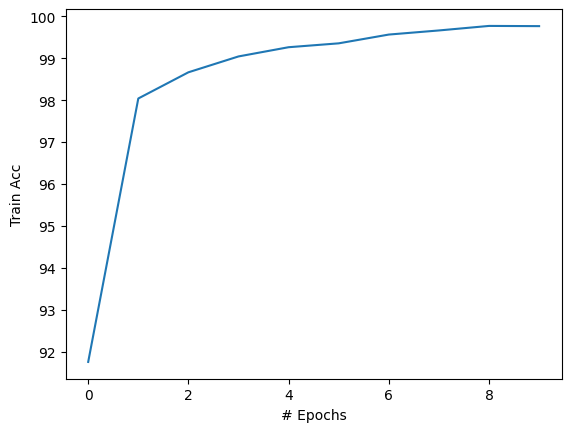

In [ ]:
#TODO Q3.3: report the final testing accuracy.
base_net = Net()

net = copy.deepcopy(base_net).to(device)
#TODO Q3.3: Adam optimizer with learning rate 0.001 and the cross-entropy loss
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

_, train_acc = train(trainloader, net, optimizer, criterion)
test_acc = test(testloader, net)

#TODO Q3.3:  Plot the training accuracy (in the y-axis) with the number of training epochs (in the x-axis)
ax = sns.lineplot(data=train_acc)
ax.set_xlabel('# Epochs')
ax.set_ylabel('Train Acc')
plt.show()

Accuracy of the network on the test set: 97.1 %


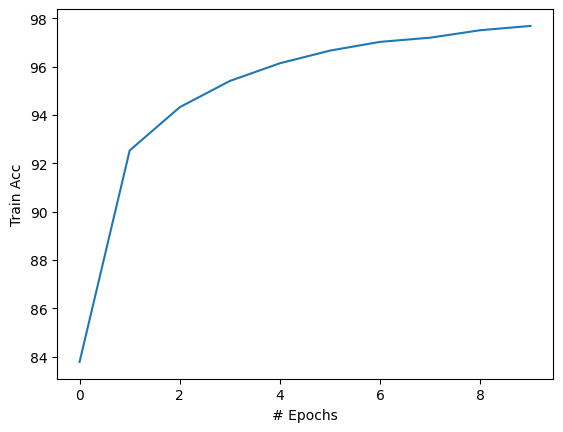

In [ ]:
#TODO Q3.4: kernel_size as 1, train and test, plot training accuracy, same as above
base_net = Net(kernel_size=1)

net = copy.deepcopy(base_net).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
_, train_acc = train(trainloader, net, optimizer, criterion)

test_acc = test(testloader, net)

ax = sns.lineplot(data=train_acc)
ax.set_xlabel('# Epochs')
ax.set_ylabel('Train Acc')
plt.show()

Accuracy of the network on the test set: 99.0 %


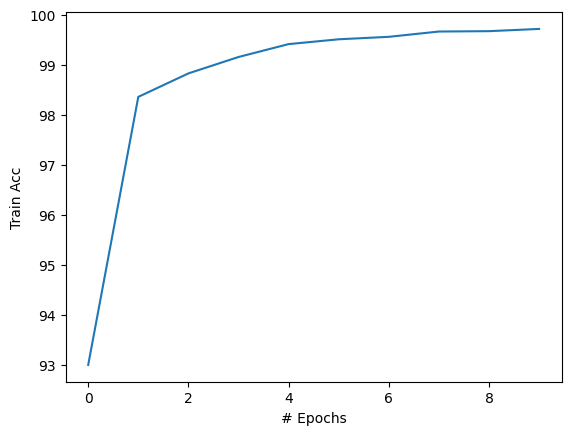

In [ ]:
#TODO Q3.4: kernel_size as 7, train and test, plot training accuracy, same as above
base_net = Net(kernel_size=7)

net = copy.deepcopy(base_net).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
_, train_acc = train(trainloader, net, optimizer, criterion)

test_acc = test(testloader, net)

ax = sns.lineplot(data=train_acc)
ax.set_xlabel('# Epochs')
ax.set_ylabel('Train Acc')
plt.show()